# Title: py_mulval load pre graph
### Purpose: Show how to load an exported json dump of mulval facts
### Author: @mjz

## Global imports and setup here

In [1]:
%matplotlib inline

#------ python libs ----------
import logging
import os
import sys
import uuid
import pathlib

#------ notebook libs ----------
import matplotlib.pyplot as plt
import networkx as nx
import graphviz
import IPython.display
import numpy as np
# import scipy.stats as st
# import scipy.special
# # bokeh plotting setup
# import bokeh.io
# import bokeh.plotting
# import bokeh.application
# import bokeh.application.handlers
# bokeh.io.output_notebook()
# notebook_url = 'localhost:8888'
py_mulval_path = r'/opt/projects/diss/py-mulval/src'
sys.path.append(py_mulval_path)

# Just importing for their flags right now
import py_mulval.py_mulval as py_mulval
import py_mulval.boromir as boromir
import py_mulval.log_util as log_util
import py_mulval.mulpy as mulpy
import py_mulval.metrics as secmet
import py_mulval.attack_graph as attack_graph
import py_mulval.mulval_fact_graph 

from py_mulval.mulval_fact_graph import FactGraph # the new thing to test here

from py_mulval import flags
FLAGS = flags.FLAGS
FLAGS([sys.argv[0]]) # dont expect cli args from jupyter

['/opt/projects/diss/jupyter_nbs/py36/lib/python3.6/site-packages/ipykernel_launcher.py']

In [2]:
print(FLAGS.flags_into_string())

--noonly_check_args
--nopdb_post_mortem
--norun_with_pdb
--norun_with_profiling
--use_cprofile_for_profiling
--noalsologtostderr
--log_dir=
--nologtostderr
--showprefixforinfo
--stderrthreshold=fatal
--verbosity=-1
--num_benchmark_copies=1
--benchmark_compatibility_checking=strict
--cloud=GCP
--after_prepare_sleep_time=0
--after_run_sleep_time=0
--nobefore_cleanup_pause
--benchmarks=standard_set
--noboot_samples
--boromir_run_count=1
--nocreate_failed_run_samples
--nocreate_started_run_sample
--nodisable_interrupt_moderation
--nodisable_rss
--nodry_run
--extra_zones=
--failed_run_samples_error_length=10240
--file_log_level=debug
--ftp_proxy=
--helpmatch=
--helpmatchmd=
--http_proxy=
--https_proxy=
--noignore_package_requirements
--nolog_dmesg
--log_level=info
--num_vms=1
--owner=toor
--persistent_timeout_minutes=240
--nopublish_after_run
--norandomize_run_order
--record_lscpu
--record_proccpu
--run_stage_iterations=1
--run_stage_retries=0
--run_stage_time=0
--ssh_options=
--nostop_afte

The MulVal wrapper we developed preserves the same flags as the original and adds some new features too.

## MulVal instrumented example end-2-end

`run.py` simply calls `mulpy.py` Main() method here and forwards flags. 

After executing attack trace we now dump our facts file to json in py_mulval.

This step generates the json we'll use next

In [3]:
# %%bash
# /opt/projects/diss/py-mulval/src/run.py --input_file=h2v1s5.P -r local_exploit_rules.P --models_dir=/opt/projects/diss/py-mulval/data/models --rules_dir=/opt/projects/diss/py-mulval/data/rules --data_dir=/opt/projects/diss/py-mulval/data

## py_mulval constants and setup here

these are passed as flags in the library, but we set them here for the notebook env

In [4]:
BASE_DIR = '/tmp/mulpy/runs'
# RUN_URI = 'a7706e9c' # from run logs above (just copied the file into our facts dir for demo)
MODEL_NAME = 'h2v1s5' 
# MODEL_NAME = 'multi_host_1' 

SEP = os.path.sep
# needed if pyxsb can't find xsb
XSB_ARCH_DIR = '/opt/apps/xsb/XSB/config/x86_64-unknown-linux-gnu'
# MulVal Install Files
MULVALROOT = '/opt/mulval'
MULVALROOT = '/opt/projects/diss/mulval/mulval'
INTERACTIONRULES = SEP.join((MULVALROOT, 'kb/interaction_rules.P'))
INTERACTIONRULES_CVSS = SEP.join(
    (MULVALROOT, 'kb/interaction_rules_with_metrics.P'))
RULES_WITH_METRIC_ARTIFACTS = SEP.join(
    (MULVALROOT, 'kb/interaction_rules_with_metric_artifacts.P'))
ATTACK_GRAPH_BIN = SEP.join((MULVALROOT, "bin/attack_graph"))
RUNNING_RULES_NAME = 'running_rules.P'
ENV_FILE_NAME = 'environment.P'
RUN_FILE_NAME = 'run.P'
# INPUT_FILE = 'single_host_1.P'
INPUT_FILE = 'h2v1s5.P'
MODELS_DIR = '/opt/projects/diss/py-mulval/data/models'
RULES_DIR = '/opt/projects/diss/py-mulval/data/rules'
FACTS_DIR = '/opt/projects/diss/py-mulval/data/facts'

if not FLAGS.rule: FLAGS['rule'].parse('local_exploit_rules.P')
FLAGS['input_file'].parse(INPUT_FILE)
FLAGS['models_dir'].parse(MODELS_DIR)
FLAGS['rules_dir'].parse(RULES_DIR)
# FLAGS['rule'].parse(RULES_DIR)


def writeFile(file_name, file_text, mode='w+'):
  """
  w  write mode
  r  read mode
  a  append mode
  w+  create file if it doesn't exist and open it in (over)write mode
      [it overwrites the file if it already exists]
  r+  open an existing file in read+write mode
  a+  create file if it doesn't exist and open it in append mode
  """
  with open(file_name, mode) as file:
    file.write(file_text)

def _SetModelsDir():
  if not FLAGS.models_dir:
    FLAGS.models_dir = SEP.join((FLAGS.base_dir, 'models'))
  logging.info('Models directory set to: {}'.format(FLAGS.models_dir))
  if not pathlib.Path(FLAGS.models_dir).exists():
    pathlib.Path(FLAGS.models_dir).mkdir(parents=True, exist_ok=True)

def _SetOutputDir():
  if not FLAGS.output_dir:
    FLAGS.output_dir = SEP.join((FLAGS.base_dir, 'output'))
  logging.info('Output directory set to: {}'.format(FLAGS.output_dir))
  if not pathlib.Path(FLAGS.output_dir).exists():
    pathlib.Path(FLAGS.output_dir).mkdir(parents=True, exist_ok=True)

def SetupMulpy():
  """Makes a new run directory and sets up flags and vars
  """
  log_util.ConfigureBasicLogging()
  logging.info('Setting up Mulpy environment...')
  if not FLAGS.run_uri: 
        FLAGS.run_uri = str(uuid.uuid4())[-8:]
  if not FLAGS.base_dir:
    FLAGS.base_dir = SEP.join(('/tmp', 'mulpy', 'runs', FLAGS.run_uri))
#   FLAGS.base_dir = SEP.join((FLAGS.base_dir, FLAGS.run_uri))
  logging.info('Base directory set to: {}'.format(FLAGS.base_dir))
  if not pathlib.Path(FLAGS.base_dir).exists():
    pathlib.Path(FLAGS.base_dir).mkdir(parents=True, exist_ok=True)

  # setup logging once we have a run_uri and base dir
  log_util.ConfigureLogging(logging.INFO,
                            SEP.join((FLAGS.base_dir, 'cat-dog.log')),
                            FLAGS.run_uri)
  # try to get cli into main log... not always trustworthy
  logging.info('running command line: %s' % ' '.join(sys.argv))
  

  _SetModelsDir()
  # _SetRulesDir() # if no rules_dir just use default set
  _SetOutputDir()
  # Copy model or example into base_dir
  if pathlib.Path(SEP.join((FLAGS.models_dir, FLAGS.input_file))).exists():
    input_p = pathlib.Path(
      SEP.join((FLAGS.models_dir, FLAGS.input_file))).read_text()
  else:
    input_p = """attackerLocated(internet).
  attackGoal(execCode(workStation,_)).

  hacl(internet, webServer, tcp, 80).
  hacl(webServer, _,  _, _).
  hacl(fileServer, _, _, _).
  hacl(workStation, _, _, _).
  hacl(H,H,_,_).

  /* configuration information of fileServer */
  networkServiceInfo(fileServer, mountd, rpc, 100005, root).
  nfsExportInfo(fileServer, '/export', _anyAccess, workStation).
  nfsExportInfo(fileServer, '/export', _anyAccess, webServer).
  vulExists(fileServer, vulID, mountd).
  vulProperty(vulID, remoteExploit, privEscalation).
  localFileProtection(fileServer, root, _, _).

  /* configuration information of webServer */
  vulExists(webServer, 'CAN-2002-0392', httpd).
  vulProperty('CAN-2002-0392', remoteExploit, privEscalation).
  networkServiceInfo(webServer , httpd, tcp , 80 , apache).

  /* configuration information of workStation */
  nfsMounted(workStation, '/usr/local/share', fileServer, '/export', read).
  """
  # write input file to working directory if it doesn't exist
  outfile = SEP.join((FLAGS.base_dir, FLAGS.input_file))
  logging.debug(('creating input file: %s') % outfile)
  if not pathlib.Path(outfile).exists():
    with open(outfile, 'w+') as file:
      file.write(input_p)
    logging.debug(('creating input file: %s') % outfile)


SetupMulpy()

2020-04-30 17:39:45,552 [MainThread  ] [INFO ] Setting up Mulpy environment...
2020-04-30 17:39:45,553 [MainThread  ] [INFO ] Base directory set to: /tmp/mulpy/runs/7898e44d
2020-04-30 17:39:45,554 7898e44d MainThread INFO     Verbose logging to: /tmp/mulpy/runs/7898e44d/cat-dog.log
2020-04-30 17:39:45,555 7898e44d MainThread INFO     running command line: /opt/projects/diss/jupyter_nbs/py36/lib/python3.6/site-packages/ipykernel_launcher.py -f /home/toor/.local/share/jupyter/runtime/kernel-915efe0f-82fe-485a-871d-7a5b0593888e.json
2020-04-30 17:39:45,555 7898e44d MainThread INFO     Models directory set to: /opt/projects/diss/py-mulval/data/models
2020-04-30 17:39:45,555 7898e44d MainThread INFO     Output directory set to: /tmp/mulpy/runs/7898e44d/output


In [5]:
FACTS_FILE = '.'.join(('mulval_facts', MODEL_NAME, 'json'))
factfile = SEP.join((FACTS_DIR, FACTS_FILE))
print(factfile)

/opt/projects/diss/py-mulval/data/facts/mulval_facts.h2v1s5.json


In [1]:
%%bash
# cat /opt/projects/diss/py-mulval/data/facts/mulval_facts.h2v1s5.json

### Setup FactGraph instance here

In [7]:
# Show a fact graph in this notebook
def plot_fg(fg, title=None):
    A = nx.nx_agraph.to_agraph(fg)
    if title:
        A.graph_attr.update(label=title, labelloc='top', labeljust='center', fontsize=24)
    # A.layout('dot', args='-Nfontsize=10 -Nwidth=".2" -Nheight=".2" -Nmargin=0 -Gfontsize=8')
    args = """
    -Gsize=17
    -Nfontname=Roboto
    -Efontname=Roboto
    -Nfontsize=14
    -Efontsize=14
    """
    A.layout('dot', args=args )
    # A.draw(self.outputDir + '/' + outfilename)
    A.draw()
    # plt.show()
    return graphviz.Source(A.to_string())

2020-04-30 17:40:46,666 7898e44d MainThread INFO     loading json file: /opt/projects/diss/py-mulval/data/facts/mulval_facts.h2v1s5.json


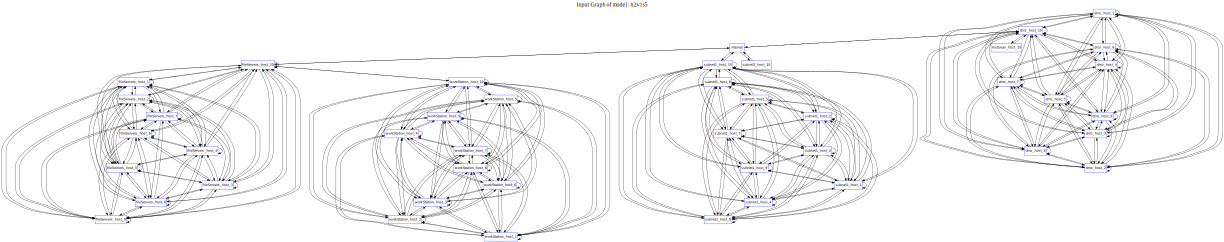

In [10]:
factgraph = FactGraph()
factgraph.name = MODEL_NAME
factgraph.load_json_file(factfile)
plot_fg(factgraph, 'Input Graph of model: {}'.format(MODEL_NAME))

# A = nx.nx_agraph.to_agraph(factgraph)
# print(A)

In [26]:
nodes =[(n, v) for n, v in factgraph.nodes(data=True)]

import pprint
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(nodes)

tmatrix = nx.adjacency_matrix(factgraph).todense()
np.set_printoptions(threshold=np.inf)
# print(tmatrix)

[ ('dmz_host_1', {'color': 'blue', 's': 's', 'shape': 'box', 'type': 'HOST'}),
  ( 'workStation_host_9',
    {'color': 'blue', 's': 's', 'shape': 'box', 'type': 'HOST'}),
  ( 'workStation_host_4',
    {'color': 'blue', 's': 's', 'shape': 'box', 'type': 'HOST'}),
  ( 'workStation_host_1',
    {'color': 'blue', 's': 's', 'shape': 'box', 'type': 'HOST'}),
  ('dmz_host_10', {'color': 'blue', 's': 's', 'shape': 'box', 'type': 'HOST'}),
  ( 'fileServers_host_9',
    {'color': 'blue', 's': 's', 'shape': 'box', 'type': 'HOST'}),
  ('dmz_host_6', {'color': 'blue', 's': 's', 'shape': 'box', 'type': 'HOST'}),
  ( 'subnet1_host_8',
    {'color': 'blue', 's': 's', 'shape': 'box', 'type': 'HOST'}),
  ( 'fileServers_host_6',
    {'color': 'blue', 's': 's', 'shape': 'box', 'type': 'HOST'}),
  ( 'fileServers_host_3',
    {'color': 'blue', 's': 's', 'shape': 'box', 'type': 'HOST'}),
  ( 'subnet1_host_4',
    {'color': 'blue', 's': 's', 'shape': 'box', 'type': 'HOST'}),
  ( 'fileServers_host_5',
    {'co